# Optimization with JuMP

Optimization models play a central role in operations research. 

In this session, we will explore the basic functionalities of JuMP, a modeling language to define and solve optimization models in Julia.

<a href="https://github.com/JuliaOpt/JuMP.jl"><img src="figures/jump.svg" alt="Julia" style="width: 500px;"/></a>

Suppose Iain wants to carry items to the pawn shop to get some extra cash. He has $N$ items, each with a weight $w_i$ and a price $p_i$. Iain hasn't been to the gym lately, so he can only carry $C$ kilos. How does he choose what to bring with him?

We can model this as an integer optimization problem:

\begin{align*}
\max& \sum_{i=1}^N p_i x_i \\
\text{s.t.}& \sum_{i=1}^N w_i x_i \leq C \\
& x_i \in \{0,1\} \quad \forall i = 1,\ldots,N
\end{align*}



## A toy example

Consider the following (small) knapsack problem:

\begin{align*}
    \max\:& x + y \\
    \text{s.t.}\:& x + 2y \leq 1.5 \\
    & x, y \in \{0,1\}
\end{align*}

How would you solve this? 

## Exhaustive enumeration

The simple way is just to consider each possible value for $x$ and $y$ and compare the cost.

![alt text](figures/tree_1.png)

In the general case, this would lead to $2^N$ possible collections of items. After Iain has weighed all of them (and verified that he can lift them at once), he just chooses the best set.

## Branch-and-bound: smart enumeration
Let's visualize this approach as a search tree:

![alt text](figures/tree_2.png)

Each node is a subproblem with 
- some variables fixed to $0$
- some variables fixed to $1$
- the remaining variables are unknown 

At each node, we have techniques to 
- find a lower bound on the objective value (i.e., find a feasible solution)
- find an upper bound on the objective value (e.g., solve the relaxation)

This leads us to a powerful tool in solving these enumeration problems: 
>If I can show you that the optimal cost for subproblem ``q`` is _less_ than the optimal cost for the original problem, the same is true for any descendent of ``q``. 


That is, we can _prune_ the tree and safely discard some nodes, kind of like this:

![alt text](figures/tree_3.png)

## Worked Example

\begin{align*}
    \max\quad& x + y \\
    \text{s.t.}\quad& x + 2y \leq 1.5 \\
    & 0 \leq x, y \leq 1 \\
    & x, y \in \{0,1\}
\end{align*}

What does the relaxation (no integrality restrictions) of this problem look like?

First, we solve the LP relaxation and get $(x^*,y^*) = (1,0.25)$. 

This isn't integer feasible, so we branch on $y$. The subproblem with $y = 1$ is infeasible, and the subproblem with $y = 0$ is feasible with solution $(x^*,y^*) = (1,0)$. This is integer feasible, so we update our lower bound. We've also exhausted the tree, so we have our optimal solution!

The branch-and-bound scheme can end up solving many subproblems, so for it to work well, we need to _prune_ large portions of the tree. 

## Branch and bound
We'll keep track of a global _lower bound_ $LB$ for our problem. Each node ``q`` will have an upper bound $UB_q$ that it inherents from its parent. If we get to the point where we have solved all subproblems (or, ideally, pruned off a great deal of them), we know that we're optimal. To do this we'll also keep track of a list $L$ of subproblems left to solve; initially, it's just the relaxation. The procedure is:

While $L$ is not empty, pick a subproblem ``q`` out of our list $L$ and solve it. 
1. ``if`` ``q`` is infeasible, ``continue``
2. ``if`` the solution is integer feasible, update the lower bound $LB$ if the cost is higher than what we had before
3. ``if``  the relaxation value is less than our global $LB$ ``continue``
4. ``else`` pick a non-integer variable $i$ and _branch_ by adding two subproblems to $L$: 
    * One with $x_i = 0$
    * Another with $x_i = 1$

Branch-and-bound is sometimes called an _implicit enumeration_ scheme because of step 3: we avoid solving any subproblems that we can prove won't produce the optimal solution.

** The "magic" of modern MIP solvers largely comes down to pruning massive portions of the tree **


## Stuff you should care about

1. Cuts (improve the _upper bounds_)
2. Heuristics (improve the _lower bounds_)
3. Presolve (_simplify_ everything before we build the tree)
4. Branching strategies (construct the tree in a smart way)

## 1. Cuts

Cuts are inequalities that are _valid_ (don't cut off any feasible integer points) and _strengthen_ the formulation (chop off some of the region feasible for the relaxation)

Three main types of cuts:

1. General purpose (e.g. CG, split, MIR)
2. Structure-specific (e.g. knapsack cover, clique)
3. Problem-specific (whatever _you_ cook up)

### Example 

Let's go back to our knapsack example and imagine that had been a bit smarter and realized that $x + \frac{4}{3}y \leq 1$ is feasible for all integer feasible points. If we add this to our formulation, we have the optimal solution at the root node!

## 2. Heuristics

You can add integer feasible solutions into the branch-and-bound scheme to improve the lower bound. These can come from

1. Problem-specific heuristics
2. Neighborhood search
3. Rounding or "polishing"

### Example

After we've already solved it twice, it's easy to see that the optimal solution for our knapsack is $(1,0)$. So, we can just start out the branch-and-bound procedure with $LB = 1$.

More generally, if we're solving a knapsack problem, one simple heuristic is to add a _greedy solution_ where you iteratively add the best available item to the sack until you run out of room. This will often be a very good solution, and is a simple example of a problem-specific heuristic scheme.

## 3. Presolve

Modern MIP solvers have a litany of techniques to simplify problems _before_ constructing the tree. 

* Variable/constraint bounds tightening
* Logical inferences
* General cleanup (remove redundant variables, constraints)

By shrinking problems, presolve potentially shrinks

* the B&B tree (fewer binary variables)
* The node solve time (smaller LP relaxations)

### Example

For our problem
\begin{align*}
    \max\:& x + y \\
    \text{s.t.}\:& x + 2y \leq 1.5 \\
    & x, y \in \{0,1\}
\end{align*}

we can perform bounds tightening to get

\begin{align*}
    \max\:& x + y \\
    \text{s.t.}\:& x + 2y \leq 1 \\
    & x, y \in \{0,1\}
\end{align*}

Then, we can reason that, since $x,y \in \{0,1\}$, we cannot have $y=1$, and so we can reduce our problem to 

\begin{align*}
    \max\:& x \\
    & x \in \{0,1\}
\end{align*}

Which we can then solve in closed form.

## 4. Branching strategies

Different paths through the B&B tree can see drastically different performance:

* Missing a node that produces a good feasible solution will mean you add nodes to your list you otherwise would have pruned
* Choosing nodes that would otherwise be pruned just slows you down

How do we know _a priori_ what a good branching strategy is, though? 

We don't really, but you can make informed guesses. 

Consider another small problem:
\begin{align*}
    \max\:& y \\
    \text{s.t.}\:& -x + y \leq \frac{1}{3} \\
    & x + y \leq \frac{4}{3} \\
    & 0 \leq x,y \leq 1 \\
    & x, y \in \{0,1\}
\end{align*}
If we solve the relaxation, we get an optimal solution of $(x^*,y^*) = (\frac{1}{2},\frac{5}{6})$.

Now we have a choice: both coordinates are fractional, so we can branch on either. 

If we branch on $y$, we get: the branch with $y=0$ gives us an optimal solution in $(0,1)$, and the $y=1$ branch is infeasible, so we have no more branches to take and we are done. 

But if we had branched on $x$ instead: the optimal solution for both branches is still fractional, so we have to branch again. If we have, say, 1000 binary variables instead of just two, we see how branching strategies can have an enormous effect on performance.

# Implementation in JuMP

Let's solve our simple knapsack problem in JuMP.

[JuMP.jl](https://github.com/JuliaOpt/JuMP.jl) is a high-level modeling language for mathematical optimization embedded in Julia. It currently supports 
- a number of open-source and commercial solvers (Artelys Knitro, BARON, Bonmin, Cbc, Clp, Couenne, CPLEX, ECOS, FICO Xpress, GLPK, Gurobi, Ipopt, MOSEK, NLopt, SCS) 
- for a variety of problem classes, including linear programming, (mixed) integer programming, second-order conic programming, semidefinite programming, and nonlinear programming.

<a href="http://www.juliaopt.org"><img src="figures/juliaopt.png" alt="JuliaOpt" style="width: 1000px;"/></a>

Take a simple knapsack problem 

\begin{align*}
    \max\:& x + y \\
    \text{s.t.}\:& x + 2y \leq 1.5 \\
    & x, y \in \{0,1\}
\end{align*}

you can easily define it in JuMP:

In [1]:
using JuMP, Gurobi
m = Model(solver=GurobiSolver())

@variable(m, x, Bin) # or Int
@variable(m, y, Bin)

@constraint(m, x + 2y ≤ 1.5)
@objective(m, Max, x + y)

print(m)

Max x + y
Subject to
 x + 2 y ≤ 1.5
 x ∈ {0,1}
 y ∈ {0,1}


and solve it

In [2]:
solve(m)

Academic license - for non-commercial use only
Optimize a model with 1 rows, 2 columns and 2 nonzeros
Variable types: 0 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%


:Optimal

This is kind of dull since Gurobi solves this before we ever get to the branch-and-bound tree! Let's cook up a problem that's a little more interesting. What about more items, and more knapsacks! If $N=100$, naïve enumeration would create $2^{100}$ nodes, which would take quite some time. How does the solver actually tackle it?

In [3]:
using LinearAlgebra
N = 100

m = Model(solver=GurobiSolver())
@variable(m, x[1:N], Bin)
for _ in 1:10
    @constraint(m, dot(rand(N), x) ≤ N / 50)
end

@objective(m, Max, dot(rand(N), x))

solve(m)

Academic license - for non-commercial use only
Optimize a model with 10 rows, 100 columns and 1000 nonzeros
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 2.7236830
Presolve time: 0.00s
Presolved: 10 rows, 100 columns, 1000 nonzeros
Variable types: 0 continuous, 100 integer (100 binary)

Root relaxation: objective 4.313656e+00, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.31366    0    7    2.72368    4.31366  58.4%     -    0s
H    0     0                       3.5201901    4.31366  22.5%     -    0s
     0     0    4.21181    0   10    3.52019    4.21181  19.6%     -    0s
     0     0    4.17991    0   10    3.52019    4.17991  18.7

:Optimal

## Understanding solver output

First, it solves the LP relaxation and reports back:
```
Root relaxation: objective 4.086983e+00, 18 iterations, 0.00 seconds
```
Now it explores the branch-and-bound tree, and updates us as it goes along. Let's look at just the first line:
```
    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.08698    0    8    0.85653    4.08698   377%     -    0s
```
We see that the information is broken down into four main columns:

1. ``Nodes``: Global node information
    * how many nodes have we looked at
    * how many do we have in our queue
2. ``Current Node``
    * objective
    * depth in the tree
    * number of noninteger variables in the solution
3. ``Objective Bounds``
    * Best incumbent (lower bound)
    * node upper bound
    * the gap between the two
4. ``Work``
    * average simplex iterations per node
    * total elapsed time

Finally, we get a neat summary of the cutting planes Gurobi found useful:
```
Cutting planes:
    Gomory: 3
  Cover: 5
  MIR: 2
  StrongCG: 1
```
All told, we explored 264  nodes, much less than the $2^{100}$ we were worried about. All this only took 1354 simplex iterations and 0.14 seconds.

Now what about those ``H``s that appear? That tells us that Gurobi ran a heuristic and found a new best solution. You can see for yourself, as the incumbent value increases while the bound remains the same:
```
    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.00770    0   12    2.97534    4.00770  34.7%     -    0s
H    0     0                       3.4427490    4.00770  16.4%     -    0s
```
You'll also sometimes see a ``*`` instead of the ``H``, which says that the feasible solution came from branching instead of heuristics.

# Solver parameters: Should you bother?

Gurobi (and other high-quality solvers) allow you to tweak a wide range of different parameters; _sometimes_ tuning these can drastically improve performance. It can be kind of intimidating, though: Gurobi has over 100 parameters, so which are the important ones?

Some useful ones:

* ``TimeLimit``: How long the solver will run before giving up.
* ``NodeLimit``: How many nodes to explore before giving up.
* ``MIPGap``: Termination criterion for relative gap $\frac{UB-LB}{LB}$.
* ``MIPFocus``: High-level controls on solver priority (proving optimality or increasing bound or finding optimal solution).
* ``Heuristics``: Determines the amount of time spent in MIP heuristics.
* ``Cuts``: Controls the aggressiveness of cut generation.
* ``Presolve``: Controls the presolve level (conservative or aggressive).

Is that it? Well, no, but you probably need domain knowledge about your problem to go much further. There's an alternative: Gurobi has a parameter tuning feature you can try to "learn" good parameter settings for a particular model. Try it out if you aren't quite happy with your performance.

## Sudoku

![Sudoku](http://upload.wikimedia.org/wikipedia/commons/f/ff/Sudoku-by-L2G-20050714.svg)

**Sudoku** is a number puzzle played on a 9x9 grid. The challenge is to place a digit between 1 and 9 inclusive in each empty cell, such that the completed grid obeys the following rules:

* Each row contains the numbers 1 to 9 once and only once.
* Each column contains the numbers 1 to 9 once and only once.
* Each 3x3 subgrid contains the numbers 1 to 9 once and only once.

>**\[Exercise\]**: Sudoku

> Model the Sudoku problem as an optimization problem.

> Write a Julia function to solve it.

** Variables **

We define binary variables 
$$ x_{i,j,k} \in \{0, 1\}, $$
for each row $i$, column $j$ and integer $k \in \{ 1,2, \dots,9\}$.

$x_{i,j,k} = 1$ iff the number $k$ appears in cell $(i,j)$

** Constraints **

- Exactly one value appears in each cell: for all $(i,j)$,
$$\sum_{k=1}^9 x_{i,j,k} = 1$$
- Each value appears in each row exactly once: for all $i$, all $k$,
$$\sum_{j=1}^9 x_{i,j,k} = 1$$
- Each value appears in each column exactly once: for all $j$, all $k$,
$$\sum_{i=1}^9 x_{i,j,k} = 1$$
- Each value appears in each 3x3 subgrid exactly once: for all subgrid $(i,j) \in \{1,4,7\}\times\{1,4,7\}$, for all $k$,
$$\sum_{i'=i}^{i+2} \sum_{j'=j}^{j+2} x_{i,j,k} = 1$$
- Match the value on known cells 

** Objective? **

Let us solve this problem in Julia now!

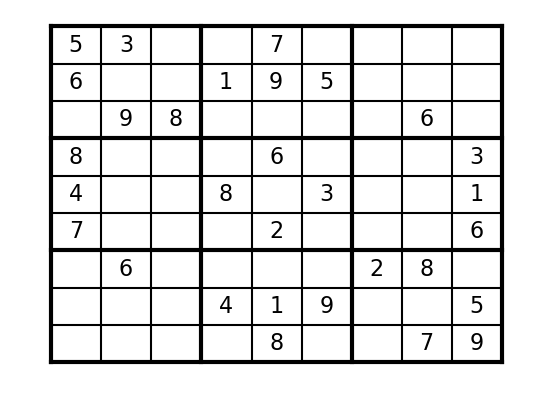

In [4]:
init_vals = [
5 3 0 0 7 0 0 0 0
6 0 0 1 9 5 0 0 0
0 9 8 0 0 0 0 6 0
8 0 0 0 6 0 0 0 3
4 0 0 8 0 3 0 0 1
7 0 0 0 2 0 0 0 6
0 6 0 0 0 0 2 8 0
0 0 0 4 1 9 0 0 5
0 0 0 0 8 0 0 7 9
]

using PyPlot
# Displays a sudoku matrix. If an initial state is provided, 
# then the new numbers are displayed in red. 
function display_sudoku(sudoku, initial_state=zeros(9,9))
    fig, ax = subplots()
    ax[:axis]("off")
    # Make sudoku basic 9x9 grid.
    for i in 0:9
        plot([i,i], [0, 9], color = "black")
        plot([0, 9], [i,i], color = "black")
    end
    # Make thicker lines to separate the 3x3 subgrids.
    for i in 0:3:9
        plot([i,i], [0,9], color = "black", linewidth = 3)
        plot([0,9], [i,i], color = "black", linewidth = 3)
    end
    # Display the values at the right square.
    for i in 0:8
        for j in 0:8 
            value = Int(sudoku[9-j,i+1])
            old_value = initial_state[9-j,i+1]
            # If an initial state is not provided (set to zero) or the value of the 
            # square did not change, the color is set to black. Otherwise, it becomes red.
            col = (sum(initial_state) == 0 || old_value == value) ? "black" : "red"
            if value > 0 # Omit zero values  
                text(i + 0.35, j + 0.33, value, size = 16, color = col)
            end
        end
    end
end
display_sudoku(init_vals)

In [5]:
sudoku = Model(solver=GurobiSolver())

@variable(sudoku, x[i=1:9, j=1:9, k=1:9], Bin)

# Exactly one value appears in each cell
@constraint(sudoku, [i=1:9, j=1:9], sum([x[i,j,k] for k in 1:9]) == 1) #constraints indexed by their indices
# Each value appears in each row exactly once.
@constraint(sudoku, row[i=1:9, k=1:9], sum([x[i,j,k] for j in 1:9]) == 1) #constraints indexed by a name+indices
# # Each value appears in each column exactly once.
@constraint(sudoku, col[j=1:9, k=1:9], sum(x[:,j,k]) == 1) #drop the variable you sum over
# Each value appears in each 3x3 subgrid exactly once.
@constraint(sudoku, subgrid[i=1:3:7,j=1:3:7,val=1:9], sum(x[i:i+2,j:j+2,val]) == 1)

# Fix given values. 
for row in 1:9, col in 1:9
    if init_vals[row,col] != 0
        @constraint(sudoku, x[row, col, init_vals[row, col]] == 1)
    end
end

print(sudoku)

Min 0
Subject to
 x[1,1,1] + x[1,1,2] + x[1,1,3] + x[1,1,4] + x[1,1,5] + x[1,1,6] + x[1,1,7] + x[1,1,8] + x[1,1,9] = 1
 x[1,2,1] + x[1,2,2] + x[1,2,3] + x[1,2,4] + x[1,2,5] + x[1,2,6] + x[1,2,7] + x[1,2,8] + x[1,2,9] = 1
 x[1,3,1] + x[1,3,2] + x[1,3,3] + x[1,3,4] + x[1,3,5] + x[1,3,6] + x[1,3,7] + x[1,3,8] + x[1,3,9] = 1
 x[1,4,1] + x[1,4,2] + x[1,4,3] + x[1,4,4] + x[1,4,5] + x[1,4,6] + x[1,4,7] + x[1,4,8] + x[1,4,9] = 1
 x[1,5,1] + x[1,5,2] + x[1,5,3] + x[1,5,4] + x[1,5,5] + x[1,5,6] + x[1,5,7] + x[1,5,8] + x[1,5,9] = 1
 x[1,6,1] + x[1,6,2] + x[1,6,3] + x[1,6,4] + x[1,6,5] + x[1,6,6] + x[1,6,7] + x[1,6,8] + x[1,6,9] = 1
 x[1,7,1] + x[1,7,2] + x[1,7,3] + x[1,7,4] + x[1,7,5] + x[1,7,6] + x[1,7,7] + x[1,7,8] + x[1,7,9] = 1
 x[1,8,1] + x[1,8,2] + x[1,8,3] + x[1,8,4] + x[1,8,5] + x[1,8,6] + x[1,8,7] + x[1,8,8] + x[1,8,9] = 1
 x[1,9,1] + x[1,9,2] + x[1,9,3] + x[1,9,4] + x[1,9,5] + x[1,9,6] + x[1,9,7] + x[1,9,8] + x[1,9,9] = 1
 x[2,1,1] + x[2,1,2] + x[2,1,3] + x[2,1,4] + x[2,1,5] + x[2,1,6] 

In [6]:
solve(sudoku)

Academic license - for non-commercial use only
Optimize a model with 354 rows, 729 columns and 2946 nonzeros
Variable types: 0 continuous, 729 integer (729 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 354 rows and 729 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


:Optimal

In [7]:
sol = sum(k * getvalue(x)[:,:,k] for k in 1:9)

9×9 Array{Float64,2}:
 5.0  3.0  4.0  6.0  7.0  8.0  9.0  1.0  2.0
 6.0  7.0  2.0  1.0  9.0  5.0  3.0  4.0  8.0
 1.0  9.0  8.0  3.0  4.0  2.0  5.0  6.0  7.0
 8.0  5.0  9.0  7.0  6.0  1.0  4.0  2.0  3.0
 4.0  2.0  6.0  8.0  5.0  3.0  7.0  9.0  1.0
 7.0  1.0  3.0  9.0  2.0  4.0  8.0  5.0  6.0
 9.0  6.0  1.0  5.0  3.0  7.0  2.0  8.0  4.0
 2.0  8.0  7.0  4.0  1.0  9.0  6.0  3.0  5.0
 3.0  4.0  5.0  2.0  8.0  6.0  1.0  7.0  9.0

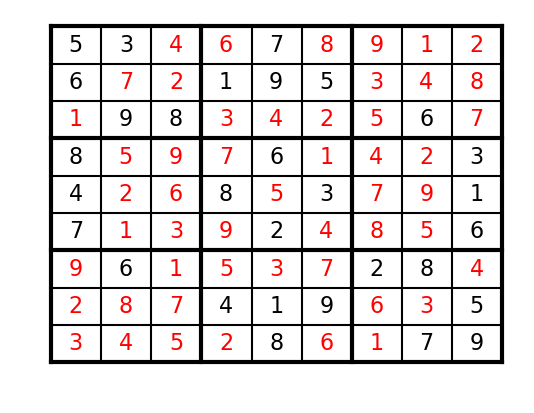

In [8]:
display_sudoku(sol, init_vals)